# Capital Bikeshare Project

Overall project aim: Explore Capital Bikeshare data prior to setting up a machine learning model to predict demand for bikes.

## Step 1: Loading data, quick quality check

Here I'll check if there are any missing data points and get a sense of the distributions of various variables.

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/train_bike.csv')

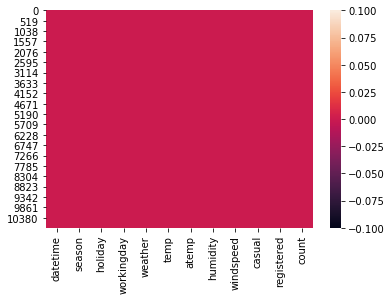

In [3]:
# check for missing data

sns.heatmap(df.isna())

Looks like there's no missing data.

## Step 2: Exploring the Capital Bikeshare data set

### Aims of data exploration

Start by checking the distributions of several variables:

- What are the differences between demand on holidays and work days?
- Differences between casual and registered riders' demand patterns?
- Weather variables:
    - What is the temperature distribution? (for actual temperature and felt temperature,`atemp`)
    - Distribution of wind speed?
    - Humidity?
    - Weather (categorical variable) and season (a higher-level categorical variable)?
    
To begin with: Look at correlations between different variables. This firstly points us in the right direction for later feature engineering, and also helps identify and therefore avoid multicolinearity in the regression model later.
- What variables is `count` correlated with?

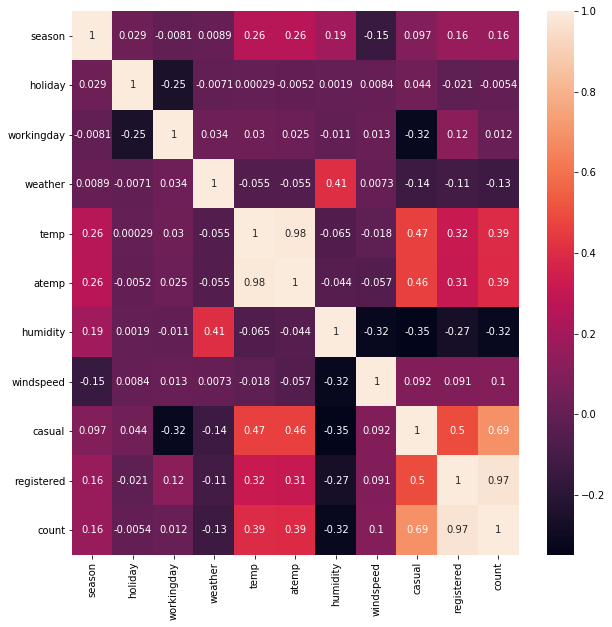

In [4]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

Some quick notes:
- (disregard casual/registered in this plot as casual + registered = count)
- workingday/holiday and casual are linked (suggesting the workday/weekend distinction is important for casual users; less so for registered users)
- temperature is  correlated with count
    - "weather" less so (possibly because it is a less granular measure and therefore captures data trends at a higher level)
    - humidity is not correlated (this is surprising given my experience of DC summers, but it's possible that humidity is confounded with season)
    - windspeed is somewhat correlated

### Plotting: Ridership Over Time By Rider Category

Start by getting a sense of how the two categories of ridership compare in their behaviour, and how ridership has evolved in the two-year time span covered by this data set.

In [21]:
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
df['date'] = pd.to_datetime(df['datetime']).dt.date
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['year'] = pd.to_datetime(df['datetime']).dt.year

In [24]:
days = df.groupby(['date']).sum()
days.reset_index(inplace = True)

In [26]:
firstdate = days['date'][0]
lastdate = days['date'][len(days['date'])-1]

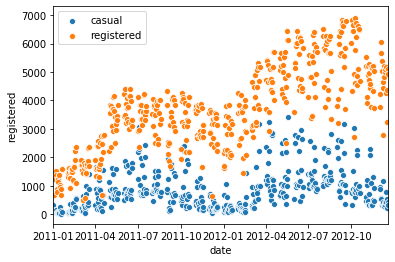

In [33]:
# plot total rentals across time, separated by ridership

sns.scatterplot(x='date', y='casual', data=days, label='casual')
sns.scatterplot(x='date', y='registered', data=days, label='registered')
plt.xlim(firstdate, lastdate)
plt.legend()

Conclusions from this plot:
- Steadily increasing overall ridership over the two-year time period.
- Surges in the summer months across both ridership groups.
- Rentals by registered riders overall consistently higher per day than rentals by casual riders -- though the two groups sometimes overlap in their rental numbers.

### Plotting: Weekdays and Holidays

- How does weekday and holiday status affect bike rentals?

- Is there a need to distinguish between holidays and workingdays?
    - Holiday: is this a public holiday or not?
    - Workingday: neither weekend nor holiday

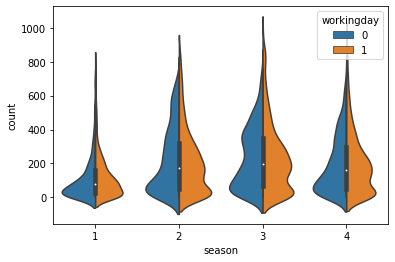

In [9]:
sns.violinplot(x='season', y='count', hue='workingday', data=df, split=True)

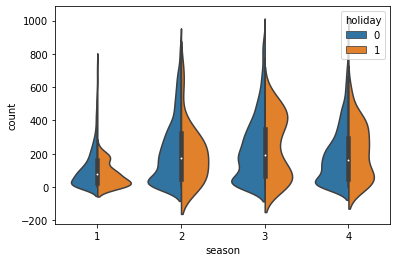

In [21]:
sns.violinplot(x='season', y='count', hue='holiday', data=df, split=True)

Conclusions from comparing holiday and workingday rental volume:
- Holidays (1; orange in this plot) behave similarly to non-working days (0; blue in the plot before)
- For simplicity I'll distinguish between workdays and non-workdays

- Seasonal patterns are similar across day type -- with highest no. of rentals in summer, and lowest ones in winter
- Long-tailed distribution for most seasons
- These graphs doesn't let us see difference between the casual and registered ridership. For this purpose, an asymmetrical violin plot could be helpful.
- The violin plot suggests that there are bimodal distributions: in summer, it seems like the counts are either very low or quite high. Except in winter, workday distributions are always bimodal. Since this is hour-by-hour data, this looks like a "rush hour" kind of phenomenon.

### Plotting: Time of day

In [32]:
hours = df.groupby(['hour', 'workingday']).sum()
hours.reset_index(inplace = True)

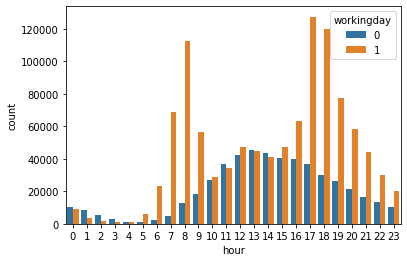

In [23]:
sns.barplot(x='hour', y='count', data=hours, hue='workingday')

**Conclusions from this plot:**

- Patterns for bike rental numbers for working/non-working days are very similar between midnight and 5 am.
- Patterns diverge between 5 am - midnight.
- On work days, there are two big spikes in bike rentals peaking at 8 and 6 pm (before and after a 9-5 work day). Bimodal distribution.
- On non-work days, bike rentals build gradually, peaking at noon. Unimodal distribution. The peak of the non-working day rental no. is equivalent to the trough between the two working day peaks.

**Conclusion: People's commute to work is probably a significant factor in bike rentals.**

Next up: If work schedules impact bike rentals, we may see differences between registered and casual ridership patterns.

### Plotting: Ridership vs. time of day

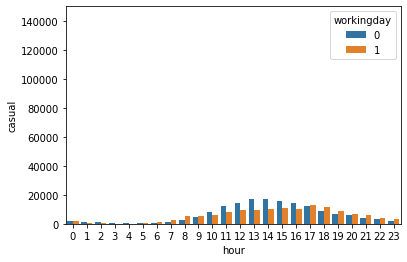

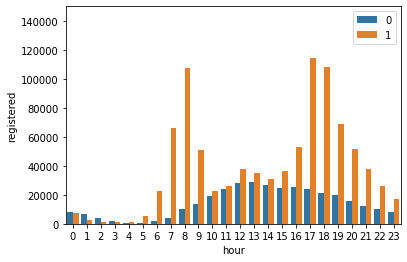

In [24]:
sns.barplot(x='hour', y='casual', data=hours, hue='workingday')
plt.ylim(0, 150_000)
plt.show()
plt.close()

sns.barplot(x='hour', y='registered', data=hours, hue='workingday')
plt.ylim(0, 150_000)
plt.legend()

**Conclusions from these plots:**

- Registered ridership dwarfs casual ridership.
- The distribution pattern for non-working days is the same for registered and casual riders, though there are many more registered riders using bikes on non-working days (looks like a factor of about 10).

### Plotting: Weather and Ridership

Look at how seasonal weather patterns affect total bike rentals. (No separation for now between casual and registered riders.)
- Different plot for each season (easier to grasp); same x and y axis
- For each season, plot relationship of rentals with:
    - Weather (1, 2, 3, 4)
    - Temperature (real and felt)
    - Humidity

In [35]:
weather = df.groupby(['season', 'weather']).mean()
weather = weather[['casual', 'registered', 'count']]
weather.reset_index(inplace = True)

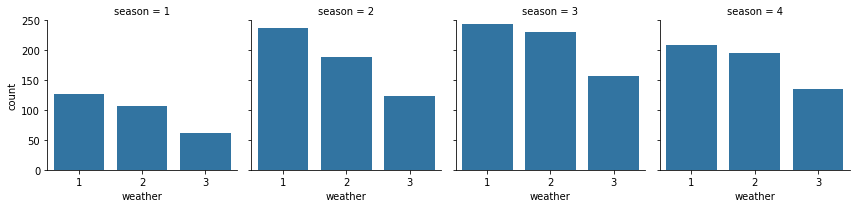

In [37]:
g=sns.FacetGrid(weather, col='season', ylim=(0, 250))
g=g.map(sns.barplot, 'weather', 'count')
plt.show()

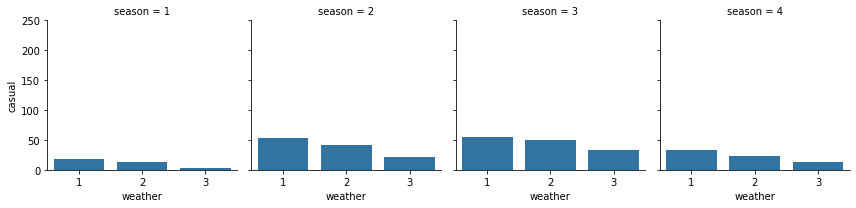

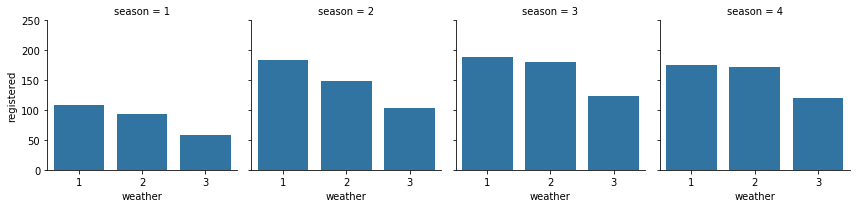

In [38]:
# Plotting: Weather II

g = sns.FacetGrid(weather, col = 'season', ylim = (0, 250))
g = g.map(sns.barplot, 'weather', 'casual')
plt.show()

g = sns.FacetGrid(weather, col = 'season', ylim = (0, 250))
g = g.map(sns.barplot, 'weather', 'registered')

Conclusions from these plots:
- As we already know, casual ridership is really low
- Across all seasons, the worse the weather (the higher the number) the lower, on average, the rentals in a given hour across the day
- In this data set there is only one recorded instance of type 4 weather, so it is not shown in the bar plots

#### Weather: Humidity

My firsthand experience of the Mid-Atlantic suggests that humidity affects rental numbers differently across seasons. Specifically, high humidity in summer feels atrocious, and you wouldn't want to be out on a bike, but in the coldest season (winter), it doesn't especially matter. Let's find out!

In [41]:
# Create a new column binning humidity

bins = pd.IntervalIndex.from_tuples([(0, 10), (10.1, 20), (20.1, 30), (30.1, 40), (40.1, 50), (50.1, 60), (60.1, 70), (70.1, 80), (80.1, 90), (90.1, 100)])
labels = ['>= 10', '>= 20', '>= 30', '>= 40', '>= 50', '>= 60', '>= 70', '>= 80', '>= 90', '>= 100']
df['hum_bins'] = pd.cut(df['humidity'], bins)

In [43]:
humid = df.groupby(['season', 'hum_bins']).mean()
humid = humid[['count', 'casual', 'registered']]
humid = humid.reset_index()

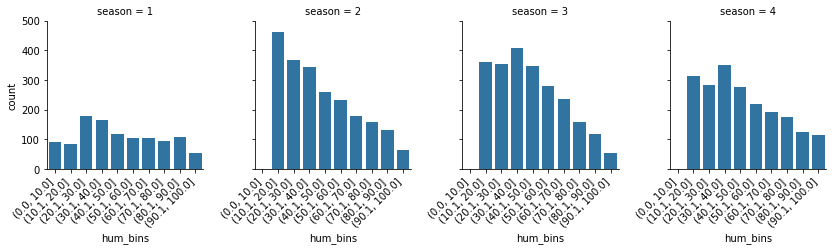

In [48]:
g = sns.FacetGrid(humid, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'hum_bins', 'count')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

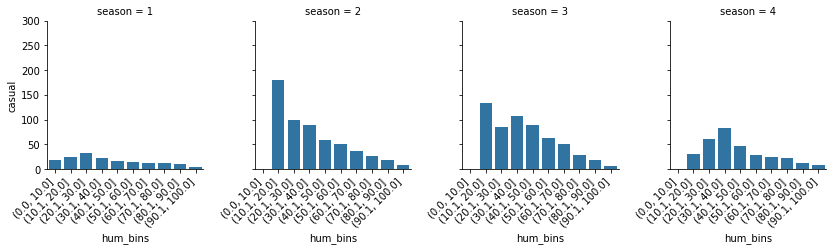

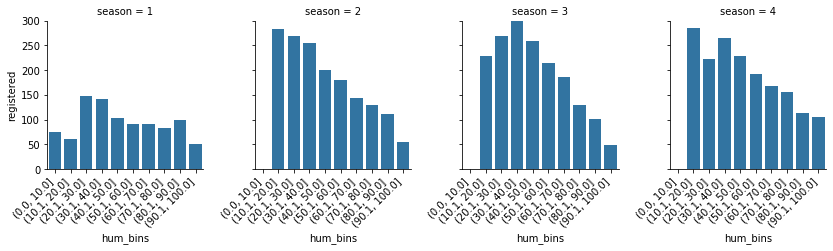

In [49]:
# Plotting humidity by ridership

g = sns.FacetGrid(humid, col = 'season', ylim = (0, 300))
g = g.map(sns.barplot, 'hum_bins', 'casual')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

g = sns.FacetGrid(humid, col = 'season', ylim = (0, 300))
g = g.map(sns.barplot, 'hum_bins', 'registered')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

Conclusions from these data:

- Across both ridership types, there is little relationship between humidity and rentals in spring.
- However, across both ridership types, rentals decrease as humidity rises.

#### Weather: Temperature

In [5]:
# Like for humidity, let's bin temp and atemp

bins_temp = pd.IntervalIndex.from_tuples([(0, 10), (10.1, 20), (20.1, 30), (30.1, 40), (40.1, 50)])

labels = ['10', '20', '30', '40', '50']

# it's the same bins and labels for the two kinds of temperature, so recycle the bins and labels
df['temp_bins'] = pd.cut(df['temp'], bins_temp)
df['atemp_bins'] = pd.cut(df['atemp'], bins_temp)

In [6]:
# New dfs that average across bins

# temp
df_temp = df.groupby(['season', 'temp_bins']).mean()
df_temp = df_temp[['count', 'casual', 'registered']]
df_temp.reset_index(inplace = True)

In [7]:
# same for atemp

df_Atemp = df.groupby(['season', 'atemp_bins']).mean()
df_Atemp = df_Atemp[['count', 'casual', 'registered']]
df_Atemp.reset_index(inplace = True)

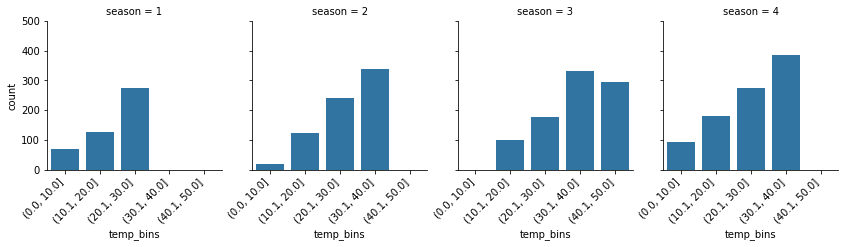

In [8]:
# Plotting temperature: Real temp

g = sns.FacetGrid(df_temp, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'temp_bins', 'count')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

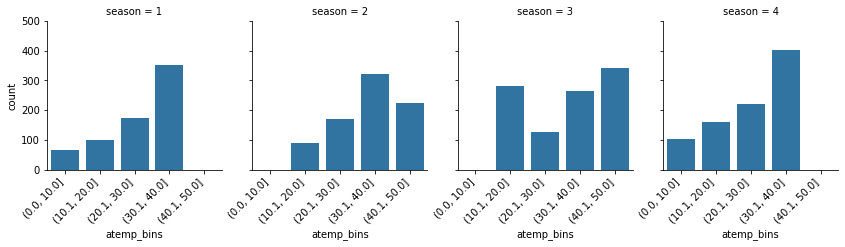

In [9]:
# Plotting temperature: Felt temp

g = sns.FacetGrid(df_Atemp, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'atemp_bins', 'count')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

#### Weather plotting: Wind speed

I'm again going to plot wind speed separately by season. A strong wind is probably unpleasant no matter what the temperature, but more moderate wind speeds may vary in their effect as to whether they are warm or cold winds.

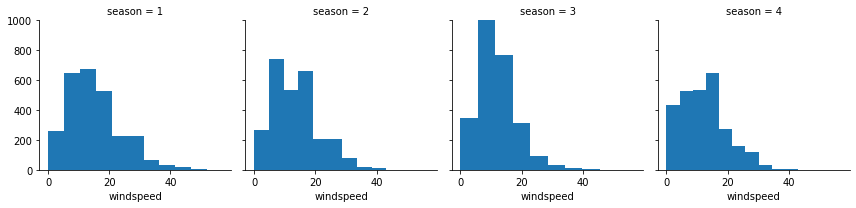

In [10]:
# Get a sense of the distribution of wind speeds in each season

g = sns.FacetGrid(df, col = 'season', ylim = (0, 1_000))
g = g.map(plt.hist, 'windspeed')
plt.show()

We see that the shape of the distribution of wind speeds doesn't differ all that much between the different seasons. In order to get much out of plotting wind speed against rental counts, I'll bin them.

In [11]:
# Binning for wind speed

# need to define some new bins
bins_wind = pd.IntervalIndex.from_tuples([(-0.1, 10), (10.1, 20), (20.1, 30), (30.1, 40), (40.1, 50), (50.1, 60)])

# create bins in new column

df['wind_bins'] = pd.cut(df['windspeed'], bins_wind)

# new df which averages within bins

df_wind = df.groupby(['season', 'wind_bins']).mean()

df_wind = df_wind[['count', 'casual', 'registered']]

df_wind.reset_index(inplace = True)

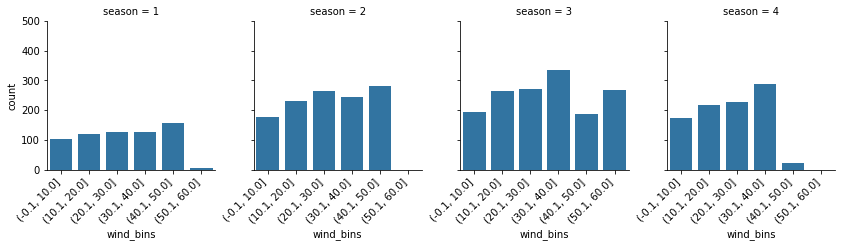

In [12]:
# Plotting wind speeds across seasons

g = sns.FacetGrid(df_wind, col = 'season', ylim = (0, 500))
g = g.map(sns.barplot, 'wind_bins', 'count')
g.set_xticklabels(rotation=45, ha='right')
plt.show()

### Conclusions from data exploration

What am I taking away from this to decide about feature exploration?

- Overall, there are some significant differences between casual and registered ridership patterns. This is interesting, but since we're only interested in the number of bikes rented at a given time, it's not relevant to further modelling.
- Climate affects bike rental numbers in a variety of ways:
    - Generally rentals peak in summer and are lowest in winter.
    - Higher humidity is inversely correlated with rentals, but this relationship does not hold in winter.
    - Higher temperatures are correlated with rentals.
    - Season appears to interact with wind speed to impact rentals. While wind speeds above 50 still enjoy robust rental numbers in summer and autumn, rentals drop steeply for those wind speeds in winter.
- Workingday affects bike rental numbers:
    - Since holidays are a subcategory of non-workingdays, I want to focus on the workingday distinction -- holidays don't add any additional information.
    - On working days, ridership patterns diverge. Registered users tend to use a bike at rush hour.
    - On non-working days, ridership patterns are more similar, peaking unimodally around lunchtime.
- Time of day is very important in predicting bike rentals. Rentals are lowest between midnight and 5 am, but then vary throughough the day, with big peaks around rush hour times (on workdays) or lunchtime (non-workdays).

In [15]:
# save the binned work

df.to_csv('../data/train_bike_engineered.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/train_bike_engineered.csv'